In [1]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os

## Load data

In [2]:
class CSVreader:
    """
    Class to read files.
    """
    def __init__(self, file_path, col_names = None):
        self.file_path = file_path
        self.col_names = col_names        
    def getDataFrame(self):
        """
        Get the data frame in the file_path.
        return: dataframe, otherwise throw IO exception
        """
        try:
            if(self.col_names):
                df = pd.read_csv(self.file_path, names = col_names)
            else:
                df = pd.read_csv(self.file_path)
            return df
        except IOError:
            print("Could not read file:", self.file_path)

In [3]:
col_names = ["att1", "att2", "att3", "att4", "att5", "att6", "label"] #provide col name if not provided already
reader = CSVreader(r"F:\1\car.data", col_names)
ori_df = reader.getDataFrame() #get the original dataframe
ori_df.head()

,att1,att2,att3,att4,att5,att6,label
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [4]:
ori_df.isnull().values.any() #check if there is any NaN value in original df

False

## Preprocess the data

In [5]:
class DataProcessor:
    """
    Class to clean the data if necessary.
    """
    def __init__(self):
        pass
    def getDummyVarsDF(self, df, dummy_fields, drop_fields = True, convert_label = False):
        """
        Clean the data, convert catagories to dummy variables
        :param df: dataframe to process
        :param dummy_fields: columne names containing catagory attributes
        :param drop_fields: drop the categorical fields or not, default is True
        :param convert_label: convert the label if necessary, default is False
        :return: cleaned dataframe
        """
        label_dict = {}
        for each in dummy_fields:
            dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
            df = pd.concat([df, dummies], axis=1)
 
        if drop_fields:
            df = self.dropAttributes(df, dummy_fields)
        if convert_label:
            df["label"] = df["label"].astype('category')
            label_dict = dict(enumerate(df['label'].cat.categories))
            df["label"] = df["label"].cat.codes
        return df, label_dict
    def splitData(self, df, split_ratio = 0.9):
        """
        Shuffle the data, then split the data to training and testing dataset
        :param df: dataframe to process
        :param split_ratio: spdefault is .9
        :return: train and test dataset
        """
        rows = df.shape[0]
        cols = df.shape[1]
        print('number of rows:{}\nnumber of columns:{}'.format(rows, cols))
        indices = np.random.permutation(rows)
        train_idx, test_idx = indices[:int(rows * split_ratio)], indices[int(rows * split_ratio):]
        train, test = df.iloc[train_idx,:], df.iloc[test_idx,:] 
        print('training data shape:{}'.format(train.shape))
        print('testing data shape:{}'.format(test.shape))    
        return train, test
        
    def getXY(self, data, label = "label", idx = 1):
        """
        Split the data to x attributes and target
        :param data: dataframe to process
        :param label: the label of the target
        :param idx: by default, assume the label is at the index 0
        :return: trainX and trainY
        """
        Y = data[label]
        X = data.iloc[:,idx:,]
        return X, Y
    def dropAttributes(self, df, col_names):
        """
        Drop specific columns of da dataframe given colmun names.
        :param df: dataframe to process
        :param col_names: the column names needs to be dropped
        :return: new dataframe after drop
        """
        if set(col_names).issubset(set(list(df.columns.values))):
            df = df.drop(col_names, axis=1)            
        else:
            print("Error: Unknown attributes.")
        return df
            


In [6]:
dp = DataProcessor()
dummy_fields = col_names[:-1]# the last column is the label
df, label_dict = dp.getDummyVarsDF(ori_df, dummy_fields, convert_label=True)
df.head()

,label,att1_high,att1_low,att1_med,att1_vhigh,att2_high,att2_low,att2_med,att2_vhigh,att3_2,...,att3_5more,att4_2,att4_4,att4_more,att5_big,att5_med,att5_small,att6_high,att6_low,att6_med
0,2,0,0,0,1,0,0,0,1,1,...,0,1,0,0,0,0,1,0,1,0
1,2,0,0,0,1,0,0,0,1,1,...,0,1,0,0,0,0,1,0,0,1
2,2,0,0,0,1,0,0,0,1,1,...,0,1,0,0,0,0,1,1,0,0
3,2,0,0,0,1,0,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
4,2,0,0,0,1,0,0,0,1,1,...,0,1,0,0,0,1,0,0,0,1


In [7]:
train, test = dp.splitData(df)
trainX, trainY = dp.getXY(train)
testX, testY = dp.getXY(test)

number of rows:1728
number of columns:22
training data shape:(1555, 22)
testing data shape:(173, 22)


In [8]:
trainX.head()

,att1_high,att1_low,att1_med,att1_vhigh,att2_high,att2_low,att2_med,att2_vhigh,att3_2,att3_3,...,att3_5more,att4_2,att4_4,att4_more,att5_big,att5_med,att5_small,att6_high,att6_low,att6_med
1528,0,1,0,0,0,0,1,0,1,0,...,0,0,1,0,1,0,0,0,0,1
406,0,0,0,1,0,1,0,0,0,0,...,1,1,0,0,0,0,1,0,0,1
325,0,0,0,1,0,1,0,0,1,0,...,0,1,0,0,0,0,1,0,0,1
696,1,0,0,0,0,0,1,0,0,1,...,0,0,0,1,0,1,0,0,1,0
1506,0,1,0,0,1,0,0,0,0,0,...,1,0,0,1,0,1,0,0,1,0


In [9]:
trainY.head()

1528    1
406     2
325     2
696     2
1506    2
Name: label, dtype: int8

In [10]:
print(trainX.shape)
print(testX.shape)

(1555, 21)
(173, 21)


## Build and compare models using different algorithms

In [42]:
from sklearn import linear_model, datasets
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools 
class ModelCompr:
    """
    Class to compare the performance of different models using cv.
    You can also input only one model(in list) and evaluate its performance.
    """
    def __init__(self, models, X, Y):
        """
        Save the models to list, and fit the models
        """
        self.models = models
        self.X = X
        self.Y = Y
        for m in self.models:
            try:
                m.fit(self.X, self.Y)
            except:
                print('An error occurred.')
        self.scores = [] #list of cv scores for each model
        self.model_names = [] #model names list
        self.fold = 0 #fold number
        self.cms = [] #confusion matrix list
    def cross_validate(self, n_fold):
        """
        Conduct cv for each model
        :param data: number of fold
        :return: None
        """
        self.fold = n_fold
        for clf in self.models:
            model_name = str(clf)
            self.model_names.append(model_name[:model_name.index('(')])
            scores = cross_val_score(clf, self.X, self.Y, cv=n_fold)
            self.scores.append(scores)
    def compr(self):
        """
        Compare the perfomance of each model at each cv
        """
        ax = plt.subplot()
        ax.set_xticks(range(self.fold))
        for i in range(len(self.models)):
            plt.plot(self.scores[i], label=self.model_names[i])
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.grid(True)
        plt.show()
    def comprAccAVG(self):
        """
        Print the accs by decreasing order for each algorithms.
        :return: None
        """
        dic = {}
        for i in range(len(self.models)):
            dic[self.model_names[i]] = sum(self.scores[i])/self.fold            
        for w in sorted(dic, key=dic.get, reverse=True):
            print ("%s has avg. accucy of: %s" % (w, dic[w]))
    def accOnTest(self, testX, testY):
        for i in range(len(self.models)):
            y_test_pred = self.models[i].predict(testX)
            cnf_matrix = confusion_matrix(testY, y_test_pred)
            self.cms.append(cnf_matrix)
            print(self.model_names[i])
            print(classification_report(testY, y_test_pred))
            print("------------------------------------------------------")
    def plotConfusionMatrix(self, cm, classes,
                              normalize=True,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        plt.rcParams['figure.figsize'] = (12, 8)
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
    def compareCMs(self, idxs): #i is the model index
        """
        Compare the confusion matrix of all seleted algorithms.
        """
        for i in idxs:
            print(self.model_names[i]) 
            plt.figure()
            if label_dict.values():
                class_names = label_dict.values()
            self.plotConfusionMatrix(self.cms[i], classes=[], normalize=True,
                      title='Confusion matrix, normalization')
            plt.show()
            print("------------------------------------------------------")       

In [43]:
logreg = linear_model.LogisticRegression(C=1e5)
svm = SVC(kernel="linear")
nb = MultinomialNB()
rf = RandomForestClassifier(max_depth=10, random_state=0)

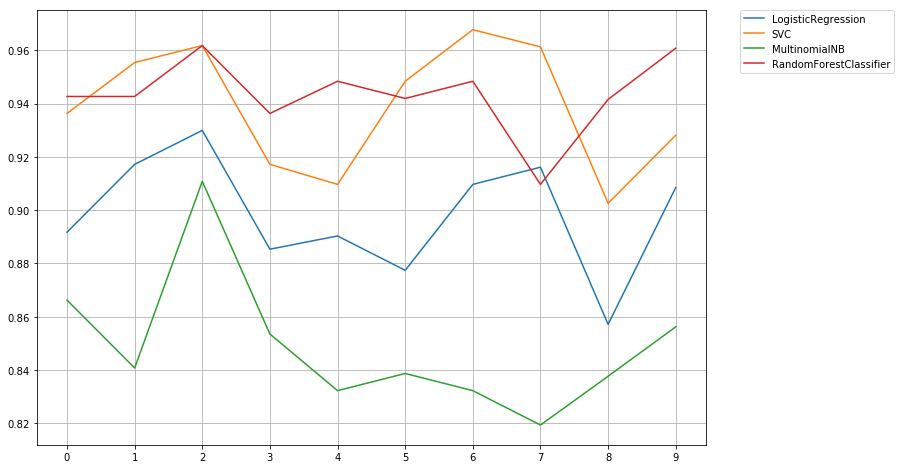

In [44]:
mc = ModelCompr([logreg, svm, nb, rf], trainX, trainY)
mc.cross_validate(10)
mc.compr()

In [45]:
mc.comprAccAVG()

RandomForestClassifier has avg. accucy of: 0.94341693425
SVC has avg. accucy of: 0.93884993889
LogisticRegression has avg. accucy of: 0.898339179792
MultinomialNB has avg. accucy of: 0.848778971277


In [46]:
mc.accOnTest(testX, testY)

LogisticRegression
             precision    recall  f1-score   support

          0       0.83      0.85      0.84        46
          1       0.67      0.40      0.50         5
          2       0.95      0.96      0.95       116
          3       1.00      1.00      1.00         6

avg / total       0.91      0.91      0.91       173

------------------------------------------------------
SVC
             precision    recall  f1-score   support

          0       0.89      0.91      0.90        46
          1       0.83      1.00      0.91         5
          2       0.97      0.96      0.97       116
          3       1.00      1.00      1.00         6

avg / total       0.95      0.95      0.95       173

------------------------------------------------------
MultinomialNB
             precision    recall  f1-score   support

          0       0.77      0.72      0.74        46
          1       0.67      0.40      0.50         5
          2       0.90      0.96      0.93       11

SVC
Normalized confusion matrix
[[ 0.91304348  0.02173913  0.06521739  0.        ]
 [ 0.          1.          0.          0.        ]
 [ 0.04310345  0.          0.95689655  0.        ]
 [ 0.          0.          0.          1.        ]]


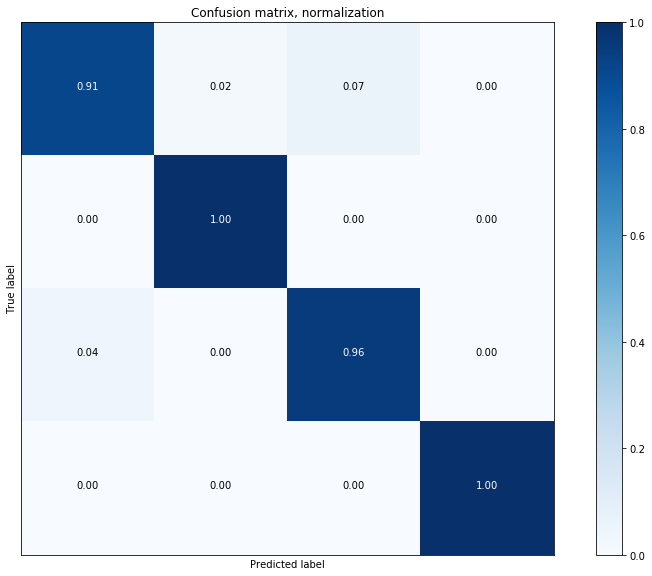

------------------------------------------------------
MultinomialNB
Normalized confusion matrix
[[ 0.7173913   0.02173913  0.26086957  0.        ]
 [ 0.6         0.4         0.          0.        ]
 [ 0.04310345  0.          0.95689655  0.        ]
 [ 0.33333333  0.          0.          0.66666667]]


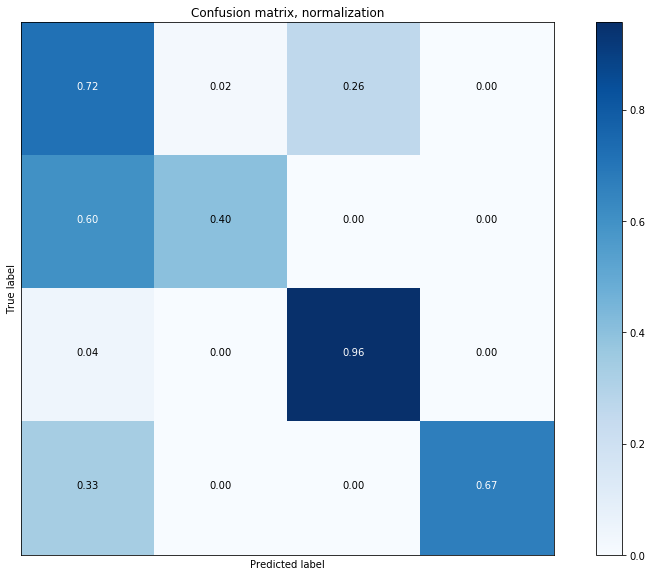

------------------------------------------------------


In [47]:
mc.compareCMs([1,2])

## Feature selection and model improvement

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

In [18]:
class FeatureSelection:
    """
    Given a model, impletement FS.
    Feature ranking with recursive feature elimination and cross-validated 
    selection of the best number of features.
    rfecv. support_ :array of shape [n_features] : The mask of selected features.
    rfecv.ranking_:
    The feature ranking, such that ranking_[i] corresponds to the ranking position of the i-th feature. 
    Selected (i.e., estimated best) features are assigned rank 1.
    """
    def __init__(self, model, trainX, trainY, k = 2, scoring = "accuracy"):
        self.model = model #the model you use
        self.X = trainX #training data input
        self.Y = trainY #training data labels
        self.k = k #fold number
        self.scoring = scoring #criteria
        self.rfecv = None
        self.y_train_pred = self.model.predict(self.X)
        self.already_selected = False
    def featureSelection(self):
        """
        Perform feature selection via cv.
        """
        self.rfecv = RFECV(estimator=self.model, step=1, cv=StratifiedKFold(self.k), scoring=self.scoring)
        self.rfecv.fit(self.X, self.Y)
        print("Optimal number of features : %d" % self.rfecv.n_features_)
        self.X_r = self.rfecv.transform(self.X)
        self.model.fit(self.X_r, self.Y)
        self.new_y_train_pred = self.model.predict(self.X_r)

    def showPlot(self):
        """
        Plot the change of cv score versus the numbers of features selected
        """
        self.featureSelection()
        self.already_selected = True
        # Plot number of features VS. cross-validation scores
        plt.figure()
        plt.xlabel("Number of features selected")
        plt.ylabel("Cross validation score (nb of correct classifications)")
        plt.plot(range(1, len(self.rfecv.grid_scores_) + 1), self.rfecv.grid_scores_)
        plt.show()
    def report(self):
        """
        Report feature selection report.
        """
        if not self.already_selected:
            self.featureSelection()
        print("rfecv.support_: (features mask)")
        print (self.rfecv.support_)
        print("rfecv.ranking_: (ranking of the features)")
        print (self.rfecv.ranking_)
        print()
        print("Before feature selection: ")
        print(classification_report(self.Y, self.y_train_pred))
        print("After feature selection: ")
        print(classification_report(self.Y, self.new_y_train_pred))  


In [19]:
logreg = linear_model.LogisticRegression(C=1e5) #the model you wish to use
logreg.fit(trainX, trainY) #fit the model before feature selection
fs = FeatureSelection(logreg, trainX, trainY, k=5) #build a FeatureSelection class to perform the task

Optimal number of features : 21


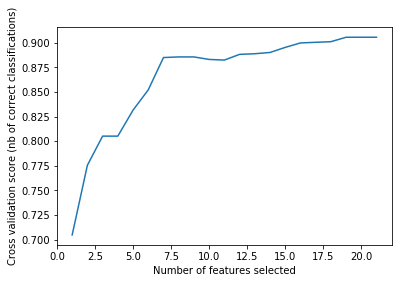

In [20]:
fs.showPlot()

In [21]:
fs.report()

rfecv.support_: (features mask)
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]
rfecv.ranking_: (ranking of the features)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

Before feature selection: 
             precision    recall  f1-score   support

          0       0.78      0.86      0.82       337
          1       0.53      0.28      0.37        61
          2       0.97      0.97      0.97      1096
          3       0.92      0.89      0.90        61

avg / total       0.91      0.91      0.91      1555

After feature selection: 
             precision    recall  f1-score   support

          0       0.78      0.86      0.82       337
          1       0.53      0.28      0.37        61
          2       0.97      0.97      0.97      1096
          3       0.92      0.89      0.90        61

avg / total       0.91      0.91      0.91      1555



## Hyper-parameters tuning using grid search method

In [22]:
from sklearn.model_selection import GridSearchCV

In [23]:
def gridSearchTuning():
    # Set the parameters by cross-validation
    tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                         'C': [1, 10, 100, 1000]},
                        {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

    scores = ['precision', 'recall']

    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()
        try:
            clf = GridSearchCV(SVC(), tuned_parameters, cv=5, scoring='%s_macro' % score)
            clf.fit(trainX, trainY)
        except:
            print("err")

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = testY, clf.predict(testX)
        print(classification_report(y_true, y_pred))
        print()

        
gridSearchTuning()

# Tuning hyper-parameters for precision



E:\Anaconda\Anaconda4.0\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\Anaconda4.0\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\Anaconda4.0\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\Anaconda4.0\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\Anac

Best parameters set found on development set:

{'C': 1000, 'kernel': 'linear'}

Grid scores on development set:

0.176 (+/-0.001) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.176 (+/-0.001) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.373 (+/-0.029) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.176 (+/-0.001) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.823 (+/-0.069) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.373 (+/-0.029) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.905 (+/-0.098) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.823 (+/-0.067) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.885 (+/-0.084) for {'C': 1, 'kernel': 'linear'}
0.914 (+/-0.069) for {'C': 10, 'kernel': 'linear'}
0.920 (+/-0.071) for {'C': 100, 'kernel': 'linear'}
0.921 (+/-0.076) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision  

## ANN with Tensorflow

In [36]:
import tensorflow as tf


learning_rate = 0.015
training_epochs = 30
batch_size = 20
display_step = 1

x = tf.placeholder(tf.float32, [None, 21])
y = tf.placeholder(tf.float32, [None, 4])

W1 = tf.Variable(tf.zeros([21, 8]))
b1 = tf.Variable(tf.zeros([8]))
y1 = tf.matmul(x, W1) + b1

W2 = tf.Variable(tf.zeros([8, 4]))
b2 = tf.Variable(tf.zeros([4]))
pred = tf.nn.softmax(tf.matmul(tf.nn.tanh(y1), W2) + b2)

cost = tf.reduce_mean(-tf.reduce_sum(y*tf.log(pred), reduction_indices=1))

optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [37]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0, len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data.iloc[i,:] for i in idx]
    labels_shuffle = [labels.iloc[i,:] for i in idx]
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [38]:
trainY_dummy = pd.get_dummies(trainY)
testY_dummy = pd.get_dummies(testY)

In [41]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(len(trainX)/batch_size)
        # Loop over batches
        for i in range(total_batch):
            batch_xs, batch_ys = next_batch(batch_size,trainX, trainY_dummy)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_xs,
                                                          y: batch_ys})            
            avg_cost += c / total_batch
        # Display logs per epoch step
        if (epoch+1) % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))
    print()    
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1)) 
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: trainX.as_matrix(), y: trainY_dummy.as_matrix()}))

Epoch: 0001 cost= 1.252693469
Epoch: 0002 cost= 1.070740837
Epoch: 0003 cost= 0.962120479
Epoch: 0004 cost= 0.905810276
Epoch: 0005 cost= 0.913339963
Epoch: 0006 cost= 0.871517263
Epoch: 0007 cost= 0.861921915
Epoch: 0008 cost= 0.854102481
Epoch: 0009 cost= 0.852761642
Epoch: 0010 cost= 0.823639061
Epoch: 0011 cost= 0.805162187
Epoch: 0012 cost= 0.841370312
Epoch: 0013 cost= 0.854349124
Epoch: 0014 cost= 0.855876741
Epoch: 0015 cost= 0.804309315
Epoch: 0016 cost= 0.818553925
Epoch: 0017 cost= 0.832427579
Epoch: 0018 cost= 0.820378979
Epoch: 0019 cost= 0.848473357
Epoch: 0020 cost= 0.829013869
Epoch: 0021 cost= 0.851026409
Epoch: 0022 cost= 0.816640855
Epoch: 0023 cost= 0.813034991
Epoch: 0024 cost= 0.813009907
Epoch: 0025 cost= 0.854317592
Epoch: 0026 cost= 0.871104436
Epoch: 0027 cost= 0.830460737
Epoch: 0028 cost= 0.820138070
Epoch: 0029 cost= 0.872497038
Epoch: 0030 cost= 0.797471845

Accuracy: 0.704823
